# Data model

> **tldr:** This notebook introduces the NeuralGCM data model, which is built on top of `coordax`. The core data structure is `Fields` - a dictionary that maps variable names to `coordax.Field` objects (arrays with attached coordinate systems). You will learn how `Fields` are used as the standard input and output for computational primitives, how model inputs are organized into nested dictionaries to handle multiple data sources, and how `Fields` can be losslessly converted to and from `xarray.Dataset` for easy inspection, visualization, and serialization

Outline:
1. `Fields` - inputs/outputs of computation primitives
2. Nested structure in model inputs
3. Inspectability and lossless conversion between `coordax` and `xarray`



In [ ]:
# imports for the tutorial.

import warnings
warnings.simplefilter('ignore')


from flax import nnx
import jax
import matplotlib.pyplot as plt
import numpy as np

import coordax as cx
from neuralgcm.experimental.atmosphere import idealized_states
from neuralgcm.experimental.core import coordinates
from neuralgcm.experimental.core import parallelism
from neuralgcm.experimental.core import transforms
from neuralgcm.experimental.core import feature_transforms
from neuralgcm.experimental.core import spherical_transforms
from neuralgcm.experimental.core import xarray_utils

## `Fields` - inputs/outputs of computation primitives

**Key concepts:**
* `Fields == dict[str, cx.Field]` is a descriptive data representation
* Most components in NeuralGCM codebase use `Fields` as inputs and outputs
* `Fields` can be losslessly converted to and from `xarray.Dataset`

### Descriptive representation using `Fields`

A simulation's state (or any intermediate result) can be fully specified by its variable names, data values, and the coordinates for all array dimensions. The `Fields` structure (`dict[str, cx.Field]`) achieves this by mapping variable names to coordinate-aware arrays. This design makes the data interpretable and easy to inspect. Let's look at a demo model state represented as `Fields`

In [ ]:
sigma = coordinates.SigmaLevels.equidistant(8)
grid = coordinates.LonLatGrid.T42()
ylm_grid = coordinates.SphericalHarmonicGrid.T42()
ylm_map = spherical_transforms.FixedYlmMapping(
    grid, ylm_grid, partition_schema_key=None, mesh=parallelism.Mesh()
)
rng = jax.random.key(3)
prognostics = idealized_states.perturbed_jw(
    ylm_map, sigma, rng, as_nodal=True, temperature_format='absolute'
)

Default `__repr__` clearly communicates variables and associated coordinates

In [ ]:
prognostics

{'vorticity': <Field (
   dims=('sigma', 'longitude', 'latitude'),
   shape=(8, 128, 64),
   axes={
     'sigma': SigmaLevels(boundaries=<np float32(9,)>, ),
     'longitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=0),
     'latitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=1),
   },
 ),
 'divergence': <Field (
   dims=('sigma', 'longitude', 'latitude'),
   shape=(8, 128, 64),
   axes={
     'sigma': SigmaLevels(boundaries=<np float32(9,)>, ),
     'longitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=0),
     'latitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=1),
   },
 ),
 'log_surface_pressure': <Field (
   dims=('longitude', 'latitude'),
   shape=(128, 64),
   axes={
     'longitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=0),
     'latitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=1),
   },
 ),
 'temperature': <Field (
   dims=('sigma', 'longitude', 'latitude'),
   shape=(8, 128, 64

Fields also support visualization using `treescope`

In [ ]:
nnx.display(prognostics)

### `[Fields, ...] → Fields` computation

Performing computations that accept and return `Fields` ensures that inspectability and coordax safety checks apply at all stages of modeling. Most components in NeuralGCM follow this `Fields, ...` → `Fields` pattern. A large class of these modules uses the `transforms.Transform` protocol, which defines a more narrow `Fields` → `Fields` mapping. This allows such transformations to be chained together to define flexible and complex computation. They generally fall into several categories:
* General transforms: apply element-wise `Field` transforms; change of coordinates; edit keys etc.
* Feature transforms: inject static features; compute features based on inputs
* Learned transforms: apply a transformation parameterized by learnable parameters

An in-depth discussions of transforms and learned transforms are presented in later, not yet released "Transforms and other modules" and "Neural nets, towers and learned transforms" tutorials.

Here we show a `Transform` example that uses a combination of feature transforms and general transforms to engineer a set of features that include:
1. Latitude features
2. All prognostics as is
3. u_wind and v_wind components computed from modal representation


In [ ]:
to_modal = transforms.ToModal(ylm_map)
uv_from_div_curl = transforms.VelocityFromModalDivCurl(ylm_map)
get_features_transform = transforms.Merge({
    'lon_lat': feature_transforms.LatitudeFeatures(grid),
    'prognostics': transforms.Identity(),
    'u_v': transforms.Sequential([to_modal, uv_from_div_curl]),
})

In [ ]:
all_features = get_features_transform(prognostics)
for k, v in all_features.items():
  print(f'feature "{k}" has dims: {v.dims}')

feature "cos_latitude" has dims: ('longitude', 'latitude')
feature "sin_latitude" has dims: ('longitude', 'latitude')
feature "vorticity" has dims: ('sigma', 'longitude', 'latitude')
feature "divergence" has dims: ('sigma', 'longitude', 'latitude')
feature "log_surface_pressure" has dims: ('longitude', 'latitude')
feature "temperature" has dims: ('sigma', 'longitude', 'latitude')
feature "u_component_of_wind" has dims: ('sigma', 'longitude', 'latitude')
feature "v_component_of_wind" has dims: ('sigma', 'longitude', 'latitude')


## Nested structure in model inputs

**Key concepts:**
* To support multiple data sources model inputs and outputs are nested in a `dict[source_name, Fields]`
* The key of the nested structure provides identity for data source or observation setting

User-facing methods for model inputs and outputs use a nested dictionary structure. This approach, which keys data by its source name (e.g., 'era5:sigma', 'ocean'), avoids name collisions (like 'ocean temperature' vs. 'air temperature') and helps partition input and output data.

For example:

In [ ]:
nested_data = {
    'era5:sigma': prognostics,
    'ocean': {'temperature': cx.field(293 * np.ones(grid.shape))},
}
print(nested_data)

{'era5:sigma': {'vorticity': <Field (
  dims=('sigma', 'longitude', 'latitude'),
  shape=(8, 128, 64),
  axes={
    'sigma': SigmaLevels(boundaries=<np float32(9,)>, ),
    'longitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=0),
    'latitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=1),
  },
), 'divergence': <Field (
  dims=('sigma', 'longitude', 'latitude'),
  shape=(8, 128, 64),
  axes={
    'sigma': SigmaLevels(boundaries=<np float32(9,)>, ),
    'longitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=0),
    'latitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=1),
  },
), 'log_surface_pressure': <Field (
  dims=('longitude', 'latitude'),
  shape=(128, 64),
  axes={
    'longitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=0),
    'latitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=1),
  },
), 'temperature': <Field (
  dims=('sigma', 'longitude', 'latitude'),
  shape=(8, 128, 64),
  axes={
 

As we've seen above, each dictionary of `Field` object can be mapped to `xarray.Dataset`. Working with further nested structure is compatible with `xarray.DataTree`, that we eventually aspire to standardize around.

## Lossless conversion between `Fields` and `xarray.Dataset`

**Key concepts:**
* `Fields` can be converted to and from `xarray.Dataset`.
* Round trips enable easy visualization and serialization to disk

Let's take a look at some examples:

First, we can inspect the prognostics `xarray.Dataset`

In [ ]:
prognostics_ds = xarray_utils.fields_to_xarray(prognostics)
prognostics_ds

<xarray.Dataset> Size: 821kB
Dimensions:               (sigma: 8, longitude: 128, latitude: 64)
Coordinates:
  * sigma                 (sigma) float32 32B 0.0625 0.1875 ... 0.8125 0.9375
  * longitude             (longitude) float64 1kB 0.0 2.812 ... 354.4 357.2
  * latitude              (latitude) float64 512B -87.86 -85.1 ... 85.1 87.86
Data variables:
    vorticity             (sigma, longitude, latitude) float32 262kB -2.357e-...
    divergence            (sigma, longitude, latitude) float32 262kB 1.369e-1...
    log_surface_pressure  (longitude, latitude) float32 33kB 11.51 ... 11.51
    temperature           (sigma, longitude, latitude) float32 262kB 217.6 .....

Visualizing intermediate results is an effective way to check computations

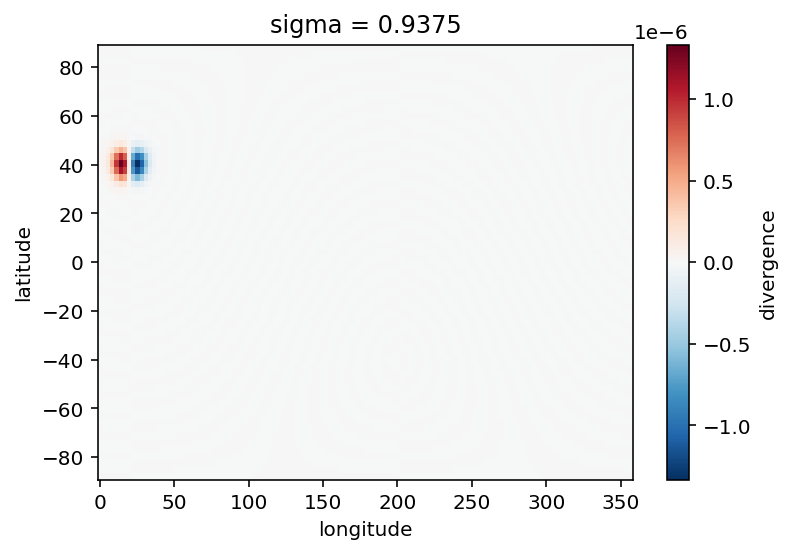

In [ ]:
prognostics_ds.divergence.isel(sigma=-1).plot(x='longitude', y='latitude')

We can also convert back to the `coordax` representation, potentially after saving it to disk.

In [ ]:
restored_state = xarray_utils.xarray_to_fields(prognostics_ds)
(restored_state['divergence'] == prognostics['divergence']).data.all()

Array(True, dtype=bool)

Since most computations deal with `Fields`, we can also easily inspect the features we engineered:

In [ ]:
features_ds = xarray_utils.fields_to_xarray(all_features)
features_ds

<xarray.Dataset> Size: 1MB
Dimensions:               (longitude: 128, latitude: 64, sigma: 8)
Coordinates:
  * longitude             (longitude) float64 1kB 0.0 2.812 ... 354.4 357.2
  * latitude              (latitude) float64 512B -87.86 -85.1 ... 85.1 87.86
  * sigma                 (sigma) float32 32B 0.0625 0.1875 ... 0.8125 0.9375
Data variables:
    cos_latitude          (longitude, latitude) float32 33kB 0.03728 ... 0.03728
    sin_latitude          (longitude, latitude) float32 33kB -0.9993 ... 0.9993
    vorticity             (sigma, longitude, latitude) float32 262kB -2.357e-...
    divergence            (sigma, longitude, latitude) float32 262kB 1.369e-1...
    log_surface_pressure  (longitude, latitude) float32 33kB 11.51 ... 11.51
    temperature           (sigma, longitude, latitude) float32 262kB 217.6 .....
    u_component_of_wind   (sigma, longitude, latitude) float32 262kB 2.952e-0...
    v_component_of_wind   (sigma, longitude, latitude) float32 262kB -1.75e-1...

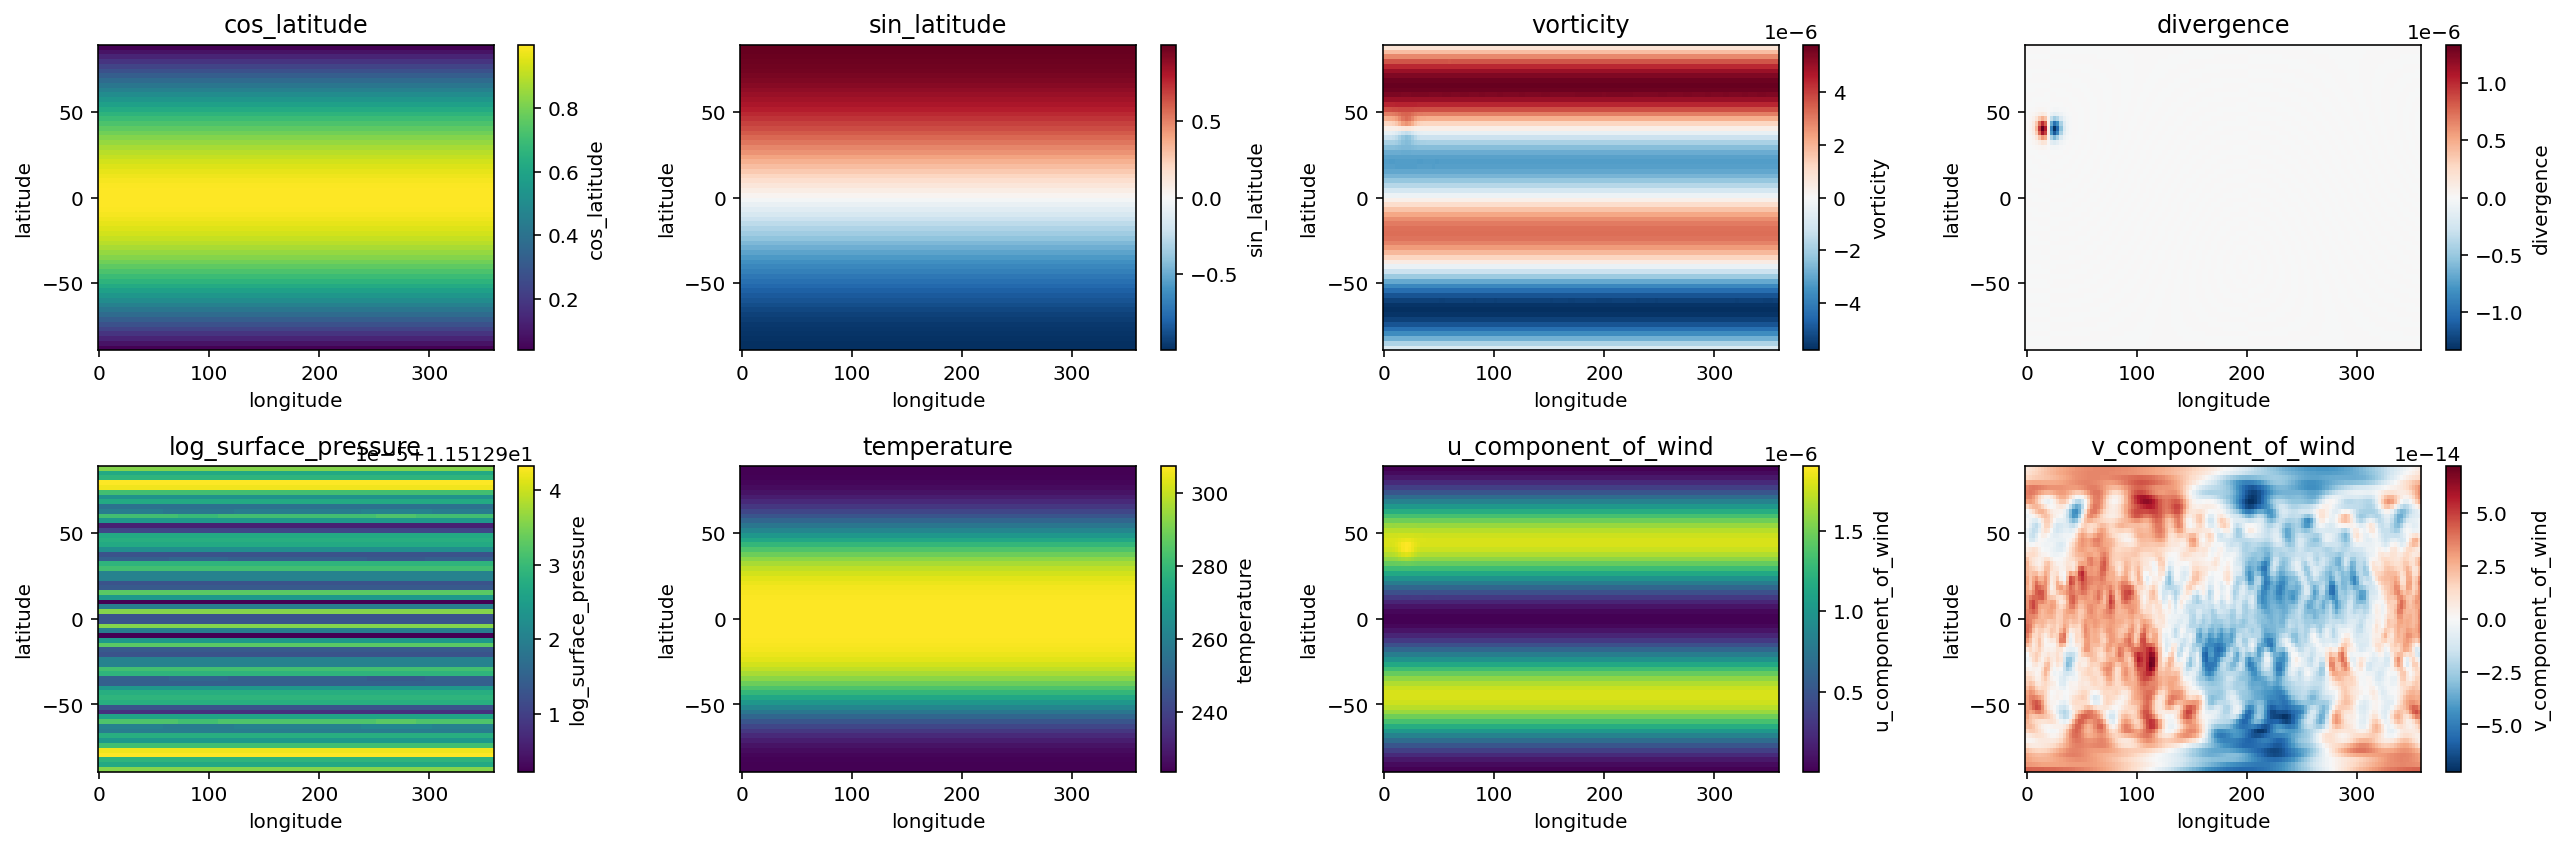

In [ ]:
fig, axarray = plt.subplots(2, 4, figsize=(18, 6))
sigma_idx = -1
for var, ax in zip(features_ds, axarray.ravel()):
  if 'sigma' in features_ds[var].dims:
    features_ds[var].isel(sigma=sigma_idx).plot(x='longitude', y='latitude', ax=ax)
  else:
    features_ds[var].plot(x='longitude', y='latitude', ax=ax)
  ax.set_title(var)
plt.tight_layout()

Quick analysis like this can help easily identify lack of feature normalization or other artifacts.